In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import qgrid
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import nltk
os.chdir(os.getcwd() + '/..')
from data_io import *
from speech import *
import time
import matplotlib.pyplot as plt
import pandas as pd

/Users/pmatias/Library/Python/3.8/lib/python/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Loading w2v window=5 dimension=100...done
Loading w2v window=5 dimension=150...done
Loading w2v window=5 dimension=200...done
Loading w2v window=10 dimension=100...done
Loading w2v window=10 dimension=150...done
Loading w2v window=10 dimension=200...done
Loading w2v window=15 dimension=100...done
Loading w2v window=15 dimension=150...done
Loading w2v window=15 dimension=200...done
Loading w2v window=20 dimension=100...done
Loading w2v window=20 dimension=150...done
Loading w2v window=20 dimension=200...done


In [21]:
PARAM_MAX_DF='param_tfidf__max_df'
PARAM_C='param_lr__C'
PARAM_NGRAM='param_tfidf__ngram_range'
PARAM_WEIGHTS='param_lr__class_weight'

In [5]:
df = pd.read_csv('data/results/2021-04-13_02h40m58/results_verbose.csv')
df

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__class_weight,param_lr__max_iter,param_lr__n_jobs,param_lr__penalty,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,7.219205,0.738569,0.406456,0.057207,1.0,NaN,100,-1,l2,...,0.400086,0.005338,115,0.578782,0.573034,0.576169,0.583747,0.572623,0.576871,0.004104
1,1,39.687808,0.853448,0.423285,0.040192,1.0,NaN,100,-1,l2,...,0.374162,0.006935,139,0.581134,0.574079,0.582441,0.588712,0.583595,0.581992,0.004718
2,2,27.968972,3.629166,0.333574,0.046423,1.0,NaN,100,-1,l2,...,0.349915,0.008266,151,0.541416,0.538019,0.546642,0.550823,0.539969,0.543374,0.004696
3,3,6.752919,0.692527,0.319168,0.041601,1.0,NaN,100,-1,l2,...,0.397368,0.005247,120,0.576692,0.570421,0.572772,0.580873,0.567398,0.573631,0.004727
4,4,40.392939,1.470748,0.423106,0.042207,1.0,NaN,100,-1,l2,...,0.372491,0.003762,143,0.581134,0.573556,0.583224,0.582963,0.579937,0.580163,0.003517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,157,36.205172,1.222061,0.361606,0.028342,30.0,balanced,100,-1,l2,...,0.460284,0.004991,3,0.999216,0.999477,0.999216,0.999739,0.999478,0.999425,0.000196
158,158,28.012984,2.549379,0.340017,0.041169,30.0,balanced,100,-1,l2,...,0.421821,0.006891,78,0.999477,0.999477,0.999477,1.000000,0.999739,0.999634,0.000209
159,159,6.281839,0.137747,0.295292,0.008280,30.0,balanced,100,-1,l2,...,0.429770,0.015756,60,0.987980,0.987196,0.987719,0.991900,0.990334,0.989026,0.001796
160,160,35.502283,1.841323,0.354902,0.021503,30.0,balanced,100,-1,l2,...,0.461329,0.004257,1,0.999216,0.999477,0.999216,0.999739,0.999739,0.999477,0.000234


In [22]:
x = df[[PARAM_MAX_DF, PARAM_C, PARAM_NGRAM, 'mean_test_score']].set_index([PARAM_MAX_DF, PARAM_C, PARAM_NGRAM])
x

mean_test_score
param_tfidf__max_df param_lr__C param_tfidf__ngram_range                 
0.5                 1.0         [1, 1]                           0.400086
                                [1, 2]                           0.374162
                                [2, 2]                           0.349915
0.7                 1.0         [1, 1]                           0.397368
                                [1, 2]                           0.372491
...                                                                   ...
                    30.0        [1, 2]                           0.460284
                                [2, 2]                           0.421821
0.9                 30.0        [1, 1]                           0.429770
                                [1, 2]                           0.461329
                                [2, 2]                           0.421821

[162 rows x 1 columns]

In [24]:
df[(df[PARAM_MAX_DF] == 0.9) & (df[PARAM_C] == 30) & (df[PARAM_NGRAM] == '[1, 2]') & (df[PARAM_WEIGHTS] == 'balanced')]['mean_train_score'].values

array([0.99947741])

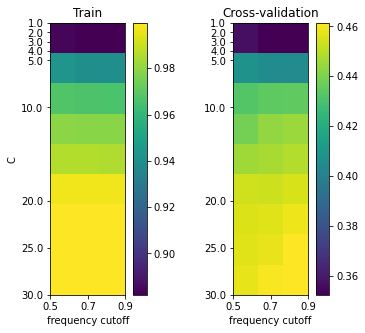

In [34]:
max_dfs = [0.5, 0.7, 0.9]
cs = [
    1.0,
    2.0,
    3.0,
    4.0,
    5.0,
    10.0,
    20.0,
    25.0,
    30.0
]

train = np.zeros((len(cs), len(max_dfs)))
for i, c in enumerate(cs):
    for j, d in enumerate(max_dfs):
        train[i,j] = df[(df[PARAM_MAX_DF] == d) & (df[PARAM_C] == c) & (df[PARAM_NGRAM] == '[1, 2]') & (df[PARAM_WEIGHTS] == 'balanced')]['mean_train_score'].values[0]
val = np.zeros((len(cs), len(max_dfs)))
for i, c in enumerate(cs):
    for j, d in enumerate(max_dfs):
        val[i,j] = df[(df[PARAM_MAX_DF] == d) & (df[PARAM_C] == c) & (df[PARAM_NGRAM] == '[1, 2]') & (df[PARAM_WEIGHTS] == 'balanced')]['mean_test_score'].values[0]

# train = pd.DataFrame(train, index=windows, columns=dims)
fig, axs = plt.subplots(1, 2, figsize=(6,5))

im = axs[0].imshow(train,
                   aspect=.05,
                   extent=[min(max_dfs), max(max_dfs), max(cs), min(cs)])
axs[0].set_xticks(max_dfs)
axs[0].set_xticklabels(max_dfs)
axs[0].set_yticks(cs)
axs[0].set_yticklabels(cs)
fig.colorbar(im, ax=axs[0])
axs[0].set_xlabel('frequency cutoff')
axs[0].set_ylabel('C')
axs[0].set_title('Train')

im = axs[1].imshow(val,
                   aspect=.05,
                   extent=[min(max_dfs), max(max_dfs), max(cs), min(cs)])
axs[1].set_xticks(max_dfs)
axs[1].set_xticklabels(max_dfs)
axs[1].set_yticks(cs)
axs[1].set_yticklabels(cs)
axs[1].set_title('Cross-validation')
axs[1].set_xlabel('frequency cutoff')
# axs[1].set_ylabel('C')
fig.colorbar(im, ax=axs[1])